### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 35  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [06:57<115:48:28, 417.33s/it]

Entrenando:   0%|          | 2/1000 [13:54<115:42:32, 417.39s/it]

Entrenando:   0%|          | 3/1000 [20:52<115:38:50, 417.58s/it]

Entrenando:   0%|          | 4/1000 [27:49<115:30:23, 417.49s/it]

Entrenando:   0%|          | 5/1000 [34:46<115:18:16, 417.18s/it]

Entrenando:   1%|          | 6/1000 [41:44<115:16:59, 417.52s/it]

Entrenando:   1%|          | 7/1000 [48:42<115:12:07, 417.65s/it]

Entrenando:   1%|          | 8/1000 [55:40<115:03:56, 417.58s/it]

Entrenando:   1%|          | 9/1000 [1:02:38<115:00:32, 417.79s/it]

Entrenando:   1%|          | 10/1000 [1:09:35<114:50:57, 417.63s/it]

Entrenando:   1%|          | 11/1000 [1:16:35<114:52:54, 418.17s/it]

Entrenando:   1%|          | 12/1000 [1:23:33<114:47:16, 418.26s/it]

Entrenando:   1%|▏         | 13/1000 [1:30:30<114:32:53, 417.80s/it]

Entrenando:   1%|▏         | 14/1000 [1:37:29<114:31:30, 418.14s/it]

Entrenando:   2%|▏         | 15/1000 [1:44:26<114:21:32, 417.96s/it]

Entrenando:   2%|▏         | 16/1000 [1:51:28<114:32:14, 419.04s/it]

Entrenando:   2%|▏         | 17/1000 [1:58:25<114:15:07, 418.42s/it]

Entrenando:   2%|▏         | 18/1000 [2:05:26<114:21:22, 419.23s/it]

Entrenando:   2%|▏         | 19/1000 [2:12:25<114:13:29, 419.17s/it]

Entrenando:   2%|▏         | 20/1000 [2:19:28<114:27:12, 420.44s/it]

Entrenando:   2%|▏         | 21/1000 [2:26:26<114:04:43, 419.49s/it]

Entrenando:   2%|▏         | 22/1000 [2:33:23<113:46:44, 418.82s/it]

Entrenando:   2%|▏         | 23/1000 [2:40:22<113:41:13, 418.91s/it]

Entrenando:   2%|▏         | 24/1000 [2:47:22<113:38:30, 419.17s/it]

Entrenando:   2%|▎         | 25/1000 [2:54:19<113:21:30, 418.55s/it]

Entrenando:   3%|▎         | 26/1000 [3:01:19<113:21:16, 418.97s/it]

Entrenando:   3%|▎         | 27/1000 [3:08:17<113:08:32, 418.61s/it]

Entrenando:   3%|▎         | 28/1000 [3:15:14<112:55:10, 418.22s/it]

Entrenando:   3%|▎         | 29/1000 [3:22:12<112:49:46, 418.32s/it]

Entrenando:   3%|▎         | 30/1000 [3:29:10<112:37:11, 417.97s/it]

Entrenando:   3%|▎         | 31/1000 [3:36:07<112:28:59, 417.89s/it]

Entrenando:   3%|▎         | 32/1000 [3:43:07<112:32:08, 418.52s/it]

Entrenando:   3%|▎         | 33/1000 [3:50:05<112:19:10, 418.15s/it]

Entrenando:   3%|▎         | 34/1000 [3:57:05<112:23:35, 418.86s/it]

Entrenando:   4%|▎         | 35/1000 [4:04:05<112:23:11, 419.27s/it]

Entrenando:   4%|▎         | 36/1000 [4:11:04<112:11:23, 418.97s/it]

Entrenando:   4%|▎         | 37/1000 [4:18:04<112:09:28, 419.28s/it]

Entrenando:   4%|▍         | 38/1000 [4:25:03<112:05:40, 419.48s/it]

Entrenando:   4%|▍         | 39/1000 [4:32:03<111:56:33, 419.35s/it]

Entrenando:   4%|▍         | 40/1000 [4:39:00<111:39:35, 418.72s/it]

Entrenando:   4%|▍         | 41/1000 [4:45:57<111:25:08, 418.26s/it]

Entrenando:   4%|▍         | 42/1000 [4:52:55<111:17:56, 418.24s/it]

Entrenando:   4%|▍         | 43/1000 [5:00:00<111:44:01, 420.32s/it]

Entrenando:   4%|▍         | 44/1000 [5:06:59<111:29:28, 419.84s/it]

Entrenando:   4%|▍         | 45/1000 [5:13:56<111:09:22, 419.02s/it]

Entrenando:   5%|▍         | 46/1000 [5:20:57<111:09:07, 419.44s/it]

Entrenando:   5%|▍         | 47/1000 [5:27:55<110:56:41, 419.10s/it]

Entrenando:   5%|▍         | 48/1000 [5:34:52<110:40:59, 418.55s/it]

Entrenando:   5%|▍         | 49/1000 [5:41:52<110:39:22, 418.89s/it]

Entrenando:   5%|▌         | 50/1000 [5:48:49<110:25:04, 418.43s/it]

Iter  50: train_loss=9.8573, val_loss=13.3660, train_suc=0.442, train_err=0.265, train_inc=0.293 | test_suc=0.405, test_err=0.279, test_inc=0.316


Entrenando:   5%|▌         | 51/1000 [5:55:47<110:17:20, 418.38s/it]

Entrenando:   5%|▌         | 52/1000 [6:02:45<110:07:41, 418.21s/it]

Entrenando:   5%|▌         | 53/1000 [6:09:42<109:52:32, 417.69s/it]

Entrenando:   5%|▌         | 54/1000 [6:16:41<109:55:04, 418.29s/it]

Entrenando:   6%|▌         | 55/1000 [6:23:42<109:57:58, 418.92s/it]

Entrenando:   6%|▌         | 56/1000 [6:30:39<109:44:26, 418.50s/it]

Entrenando:   6%|▌         | 57/1000 [6:37:36<109:30:24, 418.05s/it]

Entrenando:   6%|▌         | 58/1000 [6:44:34<109:21:58, 417.96s/it]

Entrenando:   6%|▌         | 59/1000 [6:51:32<109:17:03, 418.09s/it]

Entrenando:   6%|▌         | 60/1000 [6:58:30<109:06:20, 417.85s/it]

Entrenando:   6%|▌         | 61/1000 [7:05:27<108:58:10, 417.77s/it]

Entrenando:   6%|▌         | 62/1000 [7:12:26<108:54:40, 418.00s/it]

Entrenando:   6%|▋         | 63/1000 [7:19:24<108:47:33, 417.99s/it]

Entrenando:   6%|▋         | 64/1000 [7:26:23<108:45:51, 418.32s/it]

Entrenando:   6%|▋         | 65/1000 [7:33:23<108:46:51, 418.84s/it]

Entrenando:   7%|▋         | 66/1000 [7:40:19<108:26:24, 417.97s/it]

Entrenando:   7%|▋         | 67/1000 [7:47:17<108:17:45, 417.86s/it]

Entrenando:   7%|▋         | 68/1000 [7:54:16<108:19:36, 418.43s/it]

Entrenando:   7%|▋         | 69/1000 [8:01:14<108:11:00, 418.32s/it]

Entrenando:   7%|▋         | 70/1000 [8:08:11<107:57:55, 417.93s/it]

Entrenando:   7%|▋         | 71/1000 [8:15:09<107:49:45, 417.85s/it]

Entrenando:   7%|▋         | 72/1000 [8:22:07<107:43:06, 417.87s/it]

Entrenando:   7%|▋         | 73/1000 [8:29:07<107:44:31, 418.42s/it]

Entrenando:   7%|▋         | 74/1000 [8:36:04<107:31:35, 418.03s/it]

Entrenando:   8%|▊         | 75/1000 [8:43:05<107:38:14, 418.91s/it]

Entrenando:   8%|▊         | 76/1000 [8:50:02<107:23:56, 418.44s/it]

Entrenando:   8%|▊         | 77/1000 [8:57:02<107:25:24, 418.99s/it]

Entrenando:   8%|▊         | 78/1000 [9:04:00<107:10:44, 418.49s/it]

Entrenando:   8%|▊         | 79/1000 [9:10:57<106:58:55, 418.17s/it]

Entrenando:   8%|▊         | 80/1000 [9:17:55<106:51:16, 418.13s/it]

Entrenando:   8%|▊         | 81/1000 [9:24:52<106:39:57, 417.84s/it]

Entrenando:   8%|▊         | 82/1000 [9:31:50<106:30:30, 417.68s/it]

Entrenando:   8%|▊         | 83/1000 [9:38:50<106:34:40, 418.41s/it]

Entrenando:   8%|▊         | 84/1000 [9:45:48<106:28:35, 418.47s/it]

Entrenando:   8%|▊         | 85/1000 [9:52:47<106:21:21, 418.45s/it]

Entrenando:   9%|▊         | 86/1000 [9:59:44<106:08:03, 418.03s/it]

Entrenando:   9%|▊         | 87/1000 [10:06:42<105:59:54, 417.96s/it]

Entrenando:   9%|▉         | 88/1000 [10:13:43<106:08:12, 418.96s/it]

Entrenando:   9%|▉         | 89/1000 [10:20:40<105:51:36, 418.33s/it]

Entrenando:   9%|▉         | 90/1000 [10:27:37<105:40:09, 418.03s/it]

Entrenando:   9%|▉         | 91/1000 [10:34:37<105:40:34, 418.52s/it]

Entrenando:   9%|▉         | 92/1000 [10:41:35<105:34:37, 418.59s/it]

Entrenando:   9%|▉         | 93/1000 [10:48:33<105:22:07, 418.22s/it]

Entrenando:   9%|▉         | 94/1000 [10:55:31<105:14:13, 418.16s/it]

Entrenando:  10%|▉         | 95/1000 [11:02:30<105:11:23, 418.43s/it]

Entrenando:  10%|▉         | 96/1000 [11:09:28<105:03:10, 418.35s/it]

Entrenando:  10%|▉         | 97/1000 [11:16:25<104:49:33, 417.91s/it]

Entrenando:  10%|▉         | 98/1000 [11:23:23<104:41:21, 417.83s/it]

Entrenando:  10%|▉         | 99/1000 [11:30:23<104:45:36, 418.58s/it]

Entrenando:  10%|█         | 100/1000 [11:37:20<104:30:18, 418.02s/it]

Iter 100: train_loss=11.3277, val_loss=9.9250, train_suc=0.470, train_err=0.211, train_inc=0.320 | test_suc=0.427, test_err=0.213, test_inc=0.360


Entrenando:  10%|█         | 101/1000 [11:44:20<104:31:53, 418.59s/it]

Entrenando:  10%|█         | 102/1000 [11:51:18<104:23:47, 418.52s/it]

Entrenando:  10%|█         | 103/1000 [11:58:20<104:32:23, 419.56s/it]

Entrenando:  10%|█         | 104/1000 [12:05:20<104:28:08, 419.74s/it]

Entrenando:  10%|█         | 105/1000 [12:12:18<104:13:47, 419.25s/it]

Entrenando:  11%|█         | 106/1000 [12:19:15<103:57:35, 418.63s/it]

Entrenando:  11%|█         | 107/1000 [12:26:17<104:01:57, 419.39s/it]

Entrenando:  11%|█         | 108/1000 [12:33:18<104:02:45, 419.92s/it]

Entrenando:  11%|█         | 109/1000 [12:40:14<103:40:41, 418.90s/it]

Entrenando:  11%|█         | 110/1000 [12:47:12<103:26:49, 418.44s/it]

Entrenando:  11%|█         | 111/1000 [12:54:10<103:21:05, 418.52s/it]

Entrenando:  11%|█         | 112/1000 [13:01:08<103:09:54, 418.24s/it]

Entrenando:  11%|█▏        | 113/1000 [13:08:06<103:03:04, 418.25s/it]

Entrenando:  11%|█▏        | 114/1000 [13:15:03<102:51:50, 417.96s/it]

Entrenando:  12%|█▏        | 115/1000 [13:22:02<102:45:49, 418.02s/it]

Entrenando:  12%|█▏        | 116/1000 [13:28:58<102:31:24, 417.52s/it]

Entrenando:  12%|█▏        | 117/1000 [13:35:55<102:24:28, 417.52s/it]

Entrenando:  12%|█▏        | 118/1000 [13:42:54<102:20:42, 417.74s/it]

Entrenando:  12%|█▏        | 119/1000 [13:49:53<102:18:29, 418.06s/it]

Entrenando:  12%|█▏        | 120/1000 [13:56:50<102:08:45, 417.87s/it]

Entrenando:  12%|█▏        | 121/1000 [14:03:47<101:58:14, 417.63s/it]

Entrenando:  12%|█▏        | 122/1000 [14:10:46<101:57:07, 418.03s/it]

Entrenando:  12%|█▏        | 123/1000 [14:17:43<101:44:45, 417.66s/it]

Entrenando:  12%|█▏        | 124/1000 [14:24:40<101:36:06, 417.54s/it]

Entrenando:  12%|█▎        | 125/1000 [14:31:39<101:33:17, 417.83s/it]

Entrenando:  13%|█▎        | 126/1000 [14:38:39<101:38:36, 418.67s/it]

Entrenando:  13%|█▎        | 127/1000 [14:45:36<101:25:24, 418.24s/it]

Entrenando:  13%|█▎        | 128/1000 [14:52:34<101:15:18, 418.03s/it]

Entrenando:  13%|█▎        | 129/1000 [14:59:32<101:09:20, 418.10s/it]

Entrenando:  13%|█▎        | 130/1000 [15:06:29<100:54:57, 417.58s/it]

Entrenando:  13%|█▎        | 131/1000 [15:13:26<100:45:52, 417.44s/it]

Entrenando:  13%|█▎        | 132/1000 [15:20:23<100:39:16, 417.46s/it]

Entrenando:  13%|█▎        | 133/1000 [15:27:22<100:39:42, 417.97s/it]

Entrenando:  13%|█▎        | 134/1000 [15:34:21<100:33:47, 418.05s/it]

Entrenando:  14%|█▎        | 135/1000 [15:41:19<100:28:23, 418.15s/it]

Entrenando:  14%|█▎        | 136/1000 [15:48:16<100:18:23, 417.94s/it]

Entrenando:  14%|█▎        | 137/1000 [15:55:14<100:09:59, 417.84s/it]

Entrenando:  14%|█▍        | 138/1000 [16:02:14<100:10:30, 418.36s/it]

Entrenando:  14%|█▍        | 139/1000 [16:09:12<100:01:39, 418.23s/it]

Entrenando:  14%|█▍        | 140/1000 [16:16:09<99:53:12, 418.13s/it] 

Entrenando:  14%|█▍        | 141/1000 [16:23:10<99:54:50, 418.73s/it]

Entrenando:  14%|█▍        | 142/1000 [16:30:08<99:44:35, 418.50s/it]

Entrenando:  14%|█▍        | 143/1000 [16:37:05<99:32:38, 418.15s/it]

Entrenando:  14%|█▍        | 144/1000 [16:44:03<99:23:49, 418.02s/it]

Entrenando:  14%|█▍        | 145/1000 [16:51:00<99:12:50, 417.74s/it]

Entrenando:  15%|█▍        | 146/1000 [16:57:58<99:06:50, 417.81s/it]

Entrenando:  15%|█▍        | 147/1000 [17:04:57<99:07:48, 418.37s/it]

Entrenando:  15%|█▍        | 148/1000 [17:11:57<99:04:56, 418.66s/it]

Entrenando:  15%|█▍        | 149/1000 [17:18:54<98:52:57, 418.30s/it]

Entrenando:  15%|█▌        | 150/1000 [17:25:54<98:51:36, 418.70s/it]

Iter 150: train_loss=4.6286, val_loss=7.3425, train_suc=0.536, train_err=0.180, train_inc=0.284 | test_suc=0.488, test_err=0.172, test_inc=0.340


Entrenando:  15%|█▌        | 151/1000 [17:32:52<98:44:13, 418.67s/it]

Entrenando:  15%|█▌        | 152/1000 [17:39:51<98:36:55, 418.65s/it]

Entrenando:  15%|█▌        | 153/1000 [17:46:49<98:25:40, 418.35s/it]

Entrenando:  15%|█▌        | 154/1000 [17:53:45<98:09:26, 417.69s/it]

Entrenando:  16%|█▌        | 155/1000 [18:00:45<98:12:00, 418.37s/it]

Entrenando:  16%|█▌        | 156/1000 [18:07:41<97:58:06, 417.87s/it]

Entrenando:  16%|█▌        | 157/1000 [18:14:39<97:49:40, 417.77s/it]

Entrenando:  16%|█▌        | 158/1000 [18:21:35<97:36:52, 417.35s/it]

Entrenando:  16%|█▌        | 159/1000 [18:28:32<97:27:11, 417.16s/it]

Entrenando:  16%|█▌        | 160/1000 [18:35:29<97:20:07, 417.15s/it]

Entrenando:  16%|█▌        | 161/1000 [18:42:26<97:10:31, 416.96s/it]

Entrenando:  16%|█▌        | 162/1000 [18:49:24<97:09:45, 417.40s/it]

Entrenando:  16%|█▋        | 163/1000 [18:56:21<97:01:35, 417.32s/it]

Entrenando:  16%|█▋        | 164/1000 [19:03:18<96:52:37, 417.17s/it]

Entrenando:  16%|█▋        | 165/1000 [19:10:16<96:50:02, 417.49s/it]

Entrenando:  17%|█▋        | 166/1000 [19:17:13<96:39:32, 417.23s/it]

Entrenando:  17%|█▋        | 167/1000 [19:24:14<96:47:51, 418.33s/it]

Entrenando:  17%|█▋        | 168/1000 [19:31:11<96:35:52, 417.97s/it]

Entrenando:  17%|█▋        | 169/1000 [19:38:12<96:40:21, 418.80s/it]

Entrenando:  17%|█▋        | 170/1000 [19:45:08<96:24:26, 418.15s/it]

Entrenando:  17%|█▋        | 171/1000 [19:52:06<96:15:59, 418.05s/it]

Entrenando:  17%|█▋        | 172/1000 [19:59:03<96:05:21, 417.78s/it]

Entrenando:  17%|█▋        | 173/1000 [20:06:04<96:08:59, 418.55s/it]

Entrenando:  17%|█▋        | 174/1000 [20:13:02<95:59:49, 418.39s/it]

Entrenando:  18%|█▊        | 175/1000 [20:20:02<96:00:06, 418.92s/it]

Entrenando:  18%|█▊        | 176/1000 [20:27:00<95:50:54, 418.76s/it]

Entrenando:  18%|█▊        | 177/1000 [20:33:58<95:38:52, 418.39s/it]

Entrenando:  18%|█▊        | 178/1000 [20:40:57<95:36:48, 418.74s/it]

Entrenando:  18%|█▊        | 179/1000 [20:47:54<95:22:19, 418.20s/it]

Entrenando:  18%|█▊        | 180/1000 [20:54:52<95:13:04, 418.03s/it]

Entrenando:  18%|█▊        | 181/1000 [21:01:49<95:03:29, 417.84s/it]

Entrenando:  18%|█▊        | 182/1000 [21:08:49<95:02:24, 418.27s/it]

Entrenando:  18%|█▊        | 183/1000 [21:15:46<94:53:55, 418.16s/it]

Entrenando:  18%|█▊        | 184/1000 [21:22:47<94:55:34, 418.79s/it]

Entrenando:  18%|█▊        | 185/1000 [21:29:44<94:42:31, 418.35s/it]

Entrenando:  19%|█▊        | 186/1000 [21:36:41<94:28:57, 417.86s/it]

Entrenando:  19%|█▊        | 187/1000 [21:43:41<94:33:31, 418.71s/it]

Entrenando:  19%|█▉        | 188/1000 [21:50:38<94:19:32, 418.19s/it]

Entrenando:  19%|█▉        | 189/1000 [21:57:38<94:19:50, 418.73s/it]

Entrenando:  19%|█▉        | 190/1000 [22:04:36<94:07:08, 418.31s/it]

Entrenando:  19%|█▉        | 191/1000 [22:11:33<93:56:29, 418.03s/it]

Entrenando:  19%|█▉        | 192/1000 [22:18:31<93:48:26, 417.95s/it]

Entrenando:  19%|█▉        | 193/1000 [22:25:29<93:40:42, 417.90s/it]

Entrenando:  19%|█▉        | 194/1000 [22:32:27<93:36:03, 418.07s/it]

Entrenando:  20%|█▉        | 195/1000 [22:39:27<93:37:01, 418.66s/it]

Entrenando:  20%|█▉        | 196/1000 [22:46:25<93:28:04, 418.51s/it]

Entrenando:  20%|█▉        | 197/1000 [22:53:28<93:38:12, 419.79s/it]

Entrenando:  20%|█▉        | 198/1000 [23:00:26<93:23:42, 419.23s/it]

Entrenando:  20%|█▉        | 199/1000 [23:07:23<93:09:09, 418.66s/it]

Entrenando:  20%|██        | 200/1000 [23:14:21<92:57:45, 418.33s/it]

Iter 200: train_loss=5.7644, val_loss=6.3432, train_suc=0.571, train_err=0.166, train_inc=0.263 | test_suc=0.519, test_err=0.156, test_inc=0.325


Entrenando:  20%|██        | 201/1000 [23:21:19<92:49:37, 418.24s/it]

Entrenando:  20%|██        | 202/1000 [23:28:17<92:40:10, 418.06s/it]

Entrenando:  20%|██        | 203/1000 [23:35:17<92:44:22, 418.90s/it]

Entrenando:  20%|██        | 204/1000 [23:42:15<92:32:50, 418.56s/it]

Entrenando:  20%|██        | 205/1000 [23:49:13<92:24:30, 418.45s/it]

Entrenando:  21%|██        | 206/1000 [23:56:11<92:13:25, 418.14s/it]

Entrenando:  21%|██        | 207/1000 [24:03:09<92:05:08, 418.04s/it]

Entrenando:  21%|██        | 208/1000 [24:10:09<92:07:04, 418.72s/it]

Entrenando:  21%|██        | 209/1000 [24:17:06<91:55:19, 418.36s/it]

Entrenando:  21%|██        | 210/1000 [24:24:04<91:44:02, 418.03s/it]

Entrenando:  21%|██        | 211/1000 [24:31:02<91:36:45, 418.00s/it]

Entrenando:  21%|██        | 212/1000 [24:38:00<91:29:21, 417.97s/it]

Entrenando:  21%|██▏       | 213/1000 [24:44:58<91:25:22, 418.20s/it]

Entrenando:  21%|██▏       | 214/1000 [24:51:56<91:17:40, 418.14s/it]

Entrenando:  22%|██▏       | 215/1000 [24:58:54<91:07:04, 417.87s/it]

Entrenando:  22%|██▏       | 216/1000 [25:05:51<90:57:57, 417.70s/it]

Entrenando:  22%|██▏       | 217/1000 [25:12:48<90:50:02, 417.63s/it]

Entrenando:  22%|██▏       | 218/1000 [25:19:49<90:53:35, 418.43s/it]

Entrenando:  22%|██▏       | 219/1000 [25:26:46<90:41:55, 418.07s/it]

Entrenando:  22%|██▏       | 220/1000 [25:33:44<90:33:51, 417.99s/it]

Entrenando:  22%|██▏       | 221/1000 [25:40:43<90:32:58, 418.46s/it]

Entrenando:  22%|██▏       | 222/1000 [25:47:41<90:21:57, 418.15s/it]

Entrenando:  22%|██▏       | 223/1000 [25:54:42<90:26:25, 419.03s/it]

Entrenando:  22%|██▏       | 224/1000 [26:01:38<90:10:25, 418.33s/it]

Entrenando:  22%|██▎       | 225/1000 [26:08:36<90:00:12, 418.08s/it]

Entrenando:  23%|██▎       | 226/1000 [26:15:33<89:50:56, 417.90s/it]

Entrenando:  23%|██▎       | 227/1000 [26:22:33<89:50:38, 418.42s/it]

Entrenando:  23%|██▎       | 228/1000 [26:29:31<89:42:12, 418.31s/it]

Entrenando:  23%|██▎       | 229/1000 [26:36:28<89:29:56, 417.89s/it]

Entrenando:  23%|██▎       | 230/1000 [26:43:29<89:33:08, 418.69s/it]

Entrenando:  23%|██▎       | 231/1000 [26:50:28<89:30:23, 419.02s/it]

Entrenando:  23%|██▎       | 232/1000 [26:57:27<89:20:42, 418.81s/it]

Entrenando:  23%|██▎       | 233/1000 [27:04:28<89:22:56, 419.53s/it]

Entrenando:  23%|██▎       | 234/1000 [27:11:26<89:09:37, 419.03s/it]

Entrenando:  24%|██▎       | 235/1000 [27:18:22<88:52:51, 418.26s/it]

Entrenando:  24%|██▎       | 236/1000 [27:25:19<88:41:31, 417.92s/it]

Entrenando:  24%|██▎       | 237/1000 [27:32:17<88:33:06, 417.81s/it]

Entrenando:  24%|██▍       | 238/1000 [27:39:17<88:33:30, 418.39s/it]

Entrenando:  24%|██▍       | 239/1000 [27:46:16<88:29:33, 418.63s/it]

Entrenando:  24%|██▍       | 240/1000 [27:53:13<88:18:57, 418.34s/it]

Entrenando:  24%|██▍       | 241/1000 [28:00:10<88:07:09, 417.96s/it]

Entrenando:  24%|██▍       | 242/1000 [28:07:09<88:00:44, 418.00s/it]

Entrenando:  24%|██▍       | 243/1000 [28:14:06<87:51:19, 417.81s/it]

Entrenando:  24%|██▍       | 244/1000 [28:21:04<87:43:29, 417.74s/it]

Entrenando:  24%|██▍       | 245/1000 [28:28:01<87:35:38, 417.67s/it]

Entrenando:  25%|██▍       | 246/1000 [28:34:58<87:27:06, 417.54s/it]

Entrenando:  25%|██▍       | 247/1000 [28:42:03<87:47:52, 419.75s/it]

Entrenando:  25%|██▍       | 248/1000 [28:49:01<87:33:02, 419.13s/it]

Entrenando:  25%|██▍       | 249/1000 [28:56:01<87:31:41, 419.58s/it]

Entrenando:  25%|██▌       | 250/1000 [29:03:00<87:19:41, 419.18s/it]

Iter 250: train_loss=9.3454, val_loss=5.5353, train_suc=0.591, train_err=0.154, train_inc=0.255 | test_suc=0.540, test_err=0.144, test_inc=0.317


Entrenando:  25%|██▌       | 251/1000 [29:09:59<87:14:29, 419.32s/it]

Entrenando:  25%|██▌       | 252/1000 [29:16:57<87:01:38, 418.85s/it]

Entrenando:  25%|██▌       | 253/1000 [29:23:55<86:51:21, 418.58s/it]

Entrenando:  25%|██▌       | 254/1000 [29:30:55<86:47:44, 418.85s/it]

Entrenando:  26%|██▌       | 255/1000 [29:37:53<86:39:26, 418.75s/it]

Entrenando:  26%|██▌       | 256/1000 [29:44:53<86:37:16, 419.14s/it]

Entrenando:  26%|██▌       | 257/1000 [29:51:50<86:22:22, 418.50s/it]

Entrenando:  26%|██▌       | 258/1000 [29:58:48<86:12:25, 418.26s/it]

Entrenando:  26%|██▌       | 259/1000 [30:05:44<85:59:31, 417.77s/it]

Entrenando:  26%|██▌       | 260/1000 [30:12:43<85:54:29, 417.93s/it]

Entrenando:  26%|██▌       | 261/1000 [30:19:42<85:52:28, 418.33s/it]

Entrenando:  26%|██▌       | 262/1000 [30:26:40<85:43:49, 418.20s/it]

Entrenando:  26%|██▋       | 263/1000 [30:33:39<85:39:22, 418.40s/it]

Entrenando:  26%|██▋       | 264/1000 [30:40:38<85:33:45, 418.51s/it]

Entrenando:  26%|██▋       | 265/1000 [30:47:35<85:21:03, 418.05s/it]

Entrenando:  27%|██▋       | 266/1000 [30:54:32<85:12:03, 417.88s/it]

Entrenando:  27%|██▋       | 267/1000 [31:01:30<85:06:22, 417.98s/it]

Entrenando:  27%|██▋       | 268/1000 [31:08:31<85:09:45, 418.83s/it]

Entrenando:  27%|██▋       | 269/1000 [31:15:29<84:59:54, 418.60s/it]

Entrenando:  27%|██▋       | 270/1000 [31:22:27<84:50:48, 418.42s/it]

Entrenando:  27%|██▋       | 271/1000 [31:29:25<84:41:51, 418.26s/it]

Entrenando:  27%|██▋       | 272/1000 [31:36:27<84:49:35, 419.47s/it]

Entrenando:  27%|██▋       | 273/1000 [31:43:25<84:35:01, 418.85s/it]

Entrenando:  27%|██▋       | 274/1000 [31:50:24<84:28:56, 418.92s/it]

Entrenando:  28%|██▊       | 275/1000 [31:57:21<84:14:41, 418.32s/it]

Entrenando:  28%|██▊       | 276/1000 [32:04:17<84:01:56, 417.84s/it]

Entrenando:  28%|██▊       | 277/1000 [32:11:16<83:57:30, 418.05s/it]

Entrenando:  28%|██▊       | 278/1000 [32:18:17<83:59:34, 418.80s/it]

Entrenando:  28%|██▊       | 279/1000 [32:25:22<84:14:58, 420.66s/it]

Entrenando:  28%|██▊       | 280/1000 [32:32:19<83:55:25, 419.62s/it]

Entrenando:  28%|██▊       | 281/1000 [32:39:16<83:40:07, 418.93s/it]

Entrenando:  28%|██▊       | 282/1000 [32:46:13<83:27:25, 418.45s/it]

Entrenando:  28%|██▊       | 283/1000 [32:53:17<83:40:16, 420.11s/it]

Entrenando:  28%|██▊       | 284/1000 [33:00:14<83:19:53, 418.98s/it]

Entrenando:  28%|██▊       | 285/1000 [33:07:12<83:09:19, 418.69s/it]

Entrenando:  29%|██▊       | 286/1000 [33:14:09<82:58:02, 418.32s/it]

Entrenando:  29%|██▊       | 287/1000 [33:21:06<82:47:28, 418.02s/it]

Entrenando:  29%|██▉       | 288/1000 [33:28:09<82:55:59, 419.33s/it]

Entrenando:  29%|██▉       | 289/1000 [33:35:06<82:41:08, 418.66s/it]

Entrenando:  29%|██▉       | 290/1000 [33:42:03<82:29:04, 418.23s/it]

Entrenando:  29%|██▉       | 291/1000 [33:49:00<82:15:38, 417.68s/it]

Entrenando:  29%|██▉       | 292/1000 [33:55:57<82:06:28, 417.50s/it]

Entrenando:  29%|██▉       | 293/1000 [34:02:54<81:57:54, 417.36s/it]

Entrenando:  29%|██▉       | 294/1000 [34:09:50<81:47:12, 417.04s/it]

Entrenando:  30%|██▉       | 295/1000 [34:16:48<81:42:13, 417.21s/it]

Entrenando:  30%|██▉       | 296/1000 [34:23:48<81:47:54, 418.29s/it]

Entrenando:  30%|██▉       | 297/1000 [34:30:46<81:37:13, 417.97s/it]

Entrenando:  30%|██▉       | 298/1000 [34:37:43<81:28:04, 417.78s/it]

Entrenando:  30%|██▉       | 299/1000 [34:44:43<81:30:39, 418.60s/it]

Entrenando:  30%|███       | 300/1000 [34:51:40<81:17:25, 418.07s/it]

Iter 300: train_loss=5.6655, val_loss=5.5318, train_suc=0.602, train_err=0.148, train_inc=0.250 | test_suc=0.549, test_err=0.140, test_inc=0.310


Entrenando:  30%|███       | 301/1000 [34:58:40<81:17:11, 418.64s/it]

Entrenando:  30%|███       | 302/1000 [35:05:41<81:16:05, 419.15s/it]

Entrenando:  30%|███       | 303/1000 [35:12:40<81:08:47, 419.12s/it]

Entrenando:  30%|███       | 304/1000 [35:19:40<81:06:01, 419.49s/it]

Entrenando:  30%|███       | 305/1000 [35:26:38<80:54:28, 419.09s/it]

Entrenando:  31%|███       | 306/1000 [35:33:36<80:44:04, 418.80s/it]

Entrenando:  31%|███       | 307/1000 [35:40:38<80:45:35, 419.53s/it]

Entrenando:  31%|███       | 308/1000 [35:47:37<80:38:12, 419.50s/it]

Entrenando:  31%|███       | 309/1000 [35:54:36<80:29:13, 419.32s/it]

Entrenando:  31%|███       | 310/1000 [36:01:33<80:14:48, 418.68s/it]

Entrenando:  31%|███       | 311/1000 [36:08:32<80:08:58, 418.78s/it]

Entrenando:  31%|███       | 312/1000 [36:15:32<80:04:45, 419.02s/it]

Entrenando:  31%|███▏      | 313/1000 [36:22:29<79:53:04, 418.61s/it]

Entrenando:  31%|███▏      | 314/1000 [36:29:27<79:41:36, 418.22s/it]

Entrenando:  32%|███▏      | 315/1000 [36:36:24<79:31:51, 417.97s/it]

Entrenando:  32%|███▏      | 316/1000 [36:43:24<79:31:18, 418.54s/it]

Entrenando:  32%|███▏      | 317/1000 [36:50:25<79:32:35, 419.26s/it]

Entrenando:  32%|███▏      | 318/1000 [36:57:22<79:18:47, 418.66s/it]

Entrenando:  32%|███▏      | 319/1000 [37:04:24<79:22:18, 419.59s/it]

Entrenando:  32%|███▏      | 320/1000 [37:11:23<79:12:27, 419.33s/it]

Entrenando:  32%|███▏      | 321/1000 [37:18:23<79:10:03, 419.74s/it]

Entrenando:  32%|███▏      | 322/1000 [37:25:24<79:05:29, 419.96s/it]

Entrenando:  32%|███▏      | 323/1000 [37:32:22<78:53:45, 419.54s/it]

Entrenando:  32%|███▏      | 324/1000 [37:39:21<78:44:54, 419.37s/it]

Entrenando:  32%|███▎      | 325/1000 [37:46:19<78:32:58, 418.93s/it]

Entrenando:  33%|███▎      | 326/1000 [37:53:20<78:32:24, 419.50s/it]

Entrenando:  33%|███▎      | 327/1000 [38:00:17<78:17:24, 418.79s/it]

Entrenando:  33%|███▎      | 328/1000 [38:07:15<78:08:43, 418.64s/it]

Entrenando:  33%|███▎      | 329/1000 [38:14:13<77:57:34, 418.26s/it]

Entrenando:  33%|███▎      | 330/1000 [38:21:10<77:47:32, 417.99s/it]

Entrenando:  33%|███▎      | 331/1000 [38:28:11<77:51:15, 418.95s/it]

Entrenando:  33%|███▎      | 332/1000 [38:35:10<77:42:59, 418.83s/it]

Entrenando:  33%|███▎      | 333/1000 [38:42:07<77:30:04, 418.30s/it]

Entrenando:  33%|███▎      | 334/1000 [38:49:06<77:24:58, 418.47s/it]

Entrenando:  34%|███▎      | 335/1000 [38:56:06<77:23:19, 418.95s/it]

Entrenando:  34%|███▎      | 336/1000 [39:03:03<77:10:43, 418.44s/it]

Entrenando:  34%|███▎      | 337/1000 [39:10:01<77:01:20, 418.22s/it]

Entrenando:  34%|███▍      | 338/1000 [39:16:58<76:51:23, 417.95s/it]

Entrenando:  34%|███▍      | 339/1000 [39:24:00<76:56:22, 419.04s/it]

Entrenando:  34%|███▍      | 340/1000 [39:30:57<76:43:16, 418.48s/it]

Entrenando:  34%|███▍      | 341/1000 [39:37:57<76:41:24, 418.94s/it]

Entrenando:  34%|███▍      | 342/1000 [39:44:58<76:42:35, 419.69s/it]

Entrenando:  34%|███▍      | 343/1000 [39:52:00<76:43:34, 420.42s/it]

Entrenando:  34%|███▍      | 344/1000 [39:59:02<76:40:06, 420.74s/it]

Entrenando:  34%|███▍      | 345/1000 [40:06:01<76:27:25, 420.22s/it]

Entrenando:  35%|███▍      | 346/1000 [40:12:59<76:11:46, 419.43s/it]

Entrenando:  35%|███▍      | 347/1000 [40:19:59<76:07:39, 419.69s/it]

Entrenando:  35%|███▍      | 348/1000 [40:26:56<75:52:20, 418.93s/it]

Entrenando:  35%|███▍      | 349/1000 [40:33:58<75:54:07, 419.73s/it]

Entrenando:  35%|███▌      | 350/1000 [40:40:55<75:39:39, 419.04s/it]

Iter 350: train_loss=5.0588, val_loss=5.3182, train_suc=0.606, train_err=0.144, train_inc=0.250 | test_suc=0.553, test_err=0.137, test_inc=0.310


Entrenando:  35%|███▌      | 351/1000 [40:47:52<75:27:20, 418.55s/it]

Entrenando:  35%|███▌      | 352/1000 [40:54:50<75:17:55, 418.33s/it]

Entrenando:  35%|███▌      | 353/1000 [41:01:48<75:08:51, 418.13s/it]

Entrenando:  35%|███▌      | 354/1000 [41:08:45<74:59:05, 417.87s/it]

Entrenando:  36%|███▌      | 355/1000 [41:15:46<75:00:34, 418.66s/it]

Entrenando:  36%|███▌      | 356/1000 [41:22:43<74:48:42, 418.20s/it]

Entrenando:  36%|███▌      | 357/1000 [41:29:40<74:39:10, 417.96s/it]

Entrenando:  36%|███▌      | 358/1000 [41:36:38<74:32:04, 417.95s/it]

Entrenando:  36%|███▌      | 359/1000 [41:43:36<74:24:11, 417.87s/it]

Entrenando:  36%|███▌      | 360/1000 [41:50:33<74:16:12, 417.77s/it]

Entrenando:  36%|███▌      | 361/1000 [41:57:37<74:28:32, 419.58s/it]

Entrenando:  36%|███▌      | 362/1000 [42:04:34<74:14:11, 418.89s/it]

Entrenando:  36%|███▋      | 363/1000 [42:11:35<74:11:21, 419.28s/it]

Entrenando:  36%|███▋      | 364/1000 [42:18:34<74:05:42, 419.41s/it]

Entrenando:  36%|███▋      | 365/1000 [42:25:33<73:57:33, 419.30s/it]

Entrenando:  37%|███▋      | 366/1000 [42:32:32<73:49:09, 419.16s/it]

Entrenando:  37%|███▋      | 367/1000 [42:39:32<73:43:19, 419.27s/it]

Entrenando:  37%|███▋      | 368/1000 [42:46:32<73:39:05, 419.53s/it]

Entrenando:  37%|███▋      | 369/1000 [42:53:32<73:34:31, 419.76s/it]

Entrenando:  37%|███▋      | 370/1000 [43:00:32<73:26:34, 419.67s/it]

Entrenando:  37%|███▋      | 371/1000 [43:07:33<73:25:20, 420.22s/it]

Entrenando:  37%|███▋      | 372/1000 [43:14:31<73:11:09, 419.54s/it]

Entrenando:  37%|███▋      | 373/1000 [43:21:30<73:01:31, 419.29s/it]

Entrenando:  37%|███▋      | 374/1000 [43:28:28<72:50:38, 418.91s/it]

Entrenando:  38%|███▊      | 375/1000 [43:35:26<72:39:51, 418.55s/it]

Entrenando:  38%|███▊      | 376/1000 [43:42:27<72:41:41, 419.39s/it]

Entrenando:  38%|███▊      | 377/1000 [43:49:24<72:28:14, 418.77s/it]

Entrenando:  38%|███▊      | 378/1000 [43:56:22<72:18:36, 418.52s/it]

Entrenando:  38%|███▊      | 379/1000 [44:03:20<72:09:22, 418.30s/it]

Entrenando:  38%|███▊      | 380/1000 [44:10:21<72:10:39, 419.10s/it]

Entrenando:  38%|███▊      | 381/1000 [44:17:19<72:00:32, 418.79s/it]

Entrenando:  38%|███▊      | 382/1000 [44:24:18<71:53:28, 418.78s/it]

Entrenando:  38%|███▊      | 383/1000 [44:31:15<71:42:23, 418.39s/it]

Entrenando:  38%|███▊      | 384/1000 [44:38:12<71:31:36, 418.01s/it]

Entrenando:  38%|███▊      | 385/1000 [44:45:11<71:25:35, 418.11s/it]

Entrenando:  39%|███▊      | 386/1000 [44:52:09<71:19:08, 418.16s/it]

Entrenando:  39%|███▊      | 387/1000 [44:59:06<71:09:36, 417.91s/it]

Entrenando:  39%|███▉      | 388/1000 [45:06:04<71:01:21, 417.78s/it]

Entrenando:  39%|███▉      | 389/1000 [45:13:03<70:57:35, 418.09s/it]

Entrenando:  39%|███▉      | 390/1000 [45:20:05<71:03:21, 419.35s/it]

Entrenando:  39%|███▉      | 391/1000 [45:27:07<71:05:07, 420.21s/it]

Entrenando:  39%|███▉      | 392/1000 [45:34:04<70:48:47, 419.29s/it]

Entrenando:  39%|███▉      | 393/1000 [45:41:02<70:36:11, 418.73s/it]

Entrenando:  39%|███▉      | 394/1000 [45:48:01<70:30:19, 418.84s/it]

Entrenando:  40%|███▉      | 395/1000 [45:55:03<70:32:55, 419.79s/it]

Entrenando:  40%|███▉      | 396/1000 [46:02:03<70:26:43, 419.87s/it]

Entrenando:  40%|███▉      | 397/1000 [46:09:00<70:11:17, 419.03s/it]

Entrenando:  40%|███▉      | 398/1000 [46:15:58<70:00:04, 418.61s/it]

Entrenando:  40%|███▉      | 399/1000 [46:22:57<69:54:35, 418.76s/it]

Entrenando:  40%|████      | 400/1000 [46:29:54<69:43:15, 418.33s/it]

Iter 400: train_loss=1.8252, val_loss=4.9647, train_suc=0.610, train_err=0.140, train_inc=0.250 | test_suc=0.558, test_err=0.132, test_inc=0.311


Entrenando:  40%|████      | 401/1000 [46:36:51<69:32:23, 417.94s/it]

Entrenando:  40%|████      | 402/1000 [46:43:48<69:24:05, 417.80s/it]

Entrenando:  40%|████      | 403/1000 [46:50:46<69:17:39, 417.86s/it]

Entrenando:  40%|████      | 404/1000 [46:57:43<69:07:21, 417.52s/it]

Entrenando:  40%|████      | 405/1000 [47:04:41<69:00:10, 417.50s/it]

Entrenando:  41%|████      | 406/1000 [47:11:38<68:51:50, 417.36s/it]

Entrenando:  41%|████      | 407/1000 [47:18:39<68:56:51, 418.57s/it]

Entrenando:  41%|████      | 408/1000 [47:25:41<68:58:45, 419.47s/it]

Entrenando:  41%|████      | 409/1000 [47:32:38<68:46:22, 418.92s/it]

Entrenando:  41%|████      | 410/1000 [47:39:35<68:34:11, 418.39s/it]

Entrenando:  41%|████      | 411/1000 [47:46:34<68:27:55, 418.46s/it]

Entrenando:  41%|████      | 412/1000 [47:53:32<68:20:29, 418.42s/it]

Entrenando:  41%|████▏     | 413/1000 [48:00:34<68:23:42, 419.46s/it]

Entrenando:  41%|████▏     | 414/1000 [48:07:33<68:13:23, 419.12s/it]

Entrenando:  42%|████▏     | 415/1000 [48:14:30<68:00:47, 418.54s/it]

Entrenando:  42%|████▏     | 416/1000 [48:21:33<68:07:53, 419.99s/it]

Entrenando:  42%|████▏     | 417/1000 [48:28:32<67:57:48, 419.67s/it]

Entrenando:  42%|████▏     | 418/1000 [48:35:30<67:44:26, 419.01s/it]

Entrenando:  42%|████▏     | 419/1000 [48:42:30<67:41:44, 419.46s/it]

Entrenando:  42%|████▏     | 420/1000 [48:49:30<67:35:29, 419.53s/it]

Entrenando:  42%|████▏     | 421/1000 [48:56:27<67:23:15, 418.99s/it]

Entrenando:  42%|████▏     | 422/1000 [49:03:25<67:11:38, 418.51s/it]

Entrenando:  42%|████▏     | 423/1000 [49:10:23<67:02:50, 418.32s/it]

Entrenando:  42%|████▏     | 424/1000 [49:17:22<66:59:16, 418.67s/it]

Entrenando:  42%|████▎     | 425/1000 [49:24:21<66:52:45, 418.72s/it]

Entrenando:  43%|████▎     | 426/1000 [49:31:19<66:42:22, 418.37s/it]

Entrenando:  43%|████▎     | 427/1000 [49:38:17<66:36:22, 418.47s/it]

Entrenando:  43%|████▎     | 428/1000 [49:45:15<66:25:52, 418.10s/it]

Entrenando:  43%|████▎     | 429/1000 [49:52:14<66:21:39, 418.39s/it]

Entrenando:  43%|████▎     | 430/1000 [49:59:13<66:16:52, 418.62s/it]

Entrenando:  43%|████▎     | 431/1000 [50:06:10<66:06:20, 418.24s/it]

Entrenando:  43%|████▎     | 432/1000 [50:13:07<65:56:42, 417.96s/it]

Entrenando:  43%|████▎     | 433/1000 [50:20:06<65:51:20, 418.13s/it]

Entrenando:  43%|████▎     | 434/1000 [50:27:06<65:49:42, 418.70s/it]

Entrenando:  44%|████▎     | 435/1000 [50:34:05<65:44:27, 418.88s/it]

Entrenando:  44%|████▎     | 436/1000 [50:41:05<65:40:55, 419.25s/it]

Entrenando:  44%|████▎     | 437/1000 [50:48:05<65:34:21, 419.29s/it]

Entrenando:  44%|████▍     | 438/1000 [50:55:05<65:30:54, 419.67s/it]

Entrenando:  44%|████▍     | 439/1000 [51:02:07<65:30:06, 420.33s/it]

Entrenando:  44%|████▍     | 440/1000 [51:09:05<65:16:15, 419.60s/it]

Entrenando:  44%|████▍     | 441/1000 [51:16:02<65:02:38, 418.89s/it]

Entrenando:  44%|████▍     | 442/1000 [51:23:00<64:51:03, 418.39s/it]

Entrenando:  44%|████▍     | 443/1000 [51:29:57<64:40:56, 418.05s/it]

Entrenando:  44%|████▍     | 444/1000 [51:36:55<64:35:29, 418.22s/it]

Entrenando:  44%|████▍     | 445/1000 [51:43:54<64:29:30, 418.33s/it]

Entrenando:  45%|████▍     | 446/1000 [51:50:55<64:29:14, 419.05s/it]

Entrenando:  45%|████▍     | 447/1000 [51:57:54<64:23:21, 419.17s/it]

Entrenando:  45%|████▍     | 448/1000 [52:04:52<64:13:28, 418.86s/it]

Entrenando:  45%|████▍     | 449/1000 [52:11:53<64:11:53, 419.44s/it]

Entrenando:  45%|████▌     | 450/1000 [52:18:50<63:57:22, 418.62s/it]

Iter 450: train_loss=8.2587, val_loss=4.6824, train_suc=0.611, train_err=0.137, train_inc=0.251 | test_suc=0.559, test_err=0.128, test_inc=0.312


Entrenando:  45%|████▌     | 451/1000 [52:25:47<63:46:34, 418.21s/it]

Entrenando:  45%|████▌     | 452/1000 [52:32:49<63:48:27, 419.17s/it]

Entrenando:  45%|████▌     | 453/1000 [52:39:53<63:55:27, 420.71s/it]

Entrenando:  45%|████▌     | 454/1000 [52:46:50<63:39:19, 419.71s/it]

Entrenando:  46%|████▌     | 455/1000 [52:53:49<63:29:28, 419.39s/it]

Entrenando:  46%|████▌     | 456/1000 [53:00:53<63:36:44, 420.96s/it]

Entrenando:  46%|████▌     | 457/1000 [53:07:56<63:33:39, 421.40s/it]

Entrenando:  46%|████▌     | 458/1000 [53:14:54<63:18:59, 420.55s/it]

Entrenando:  46%|████▌     | 459/1000 [53:21:48<62:51:49, 418.32s/it]

Entrenando:  46%|████▌     | 460/1000 [53:28:47<62:48:14, 418.69s/it]

Entrenando:  46%|████▌     | 461/1000 [53:35:45<62:39:51, 418.54s/it]

Entrenando:  46%|████▌     | 462/1000 [53:42:45<62:35:11, 418.79s/it]

Entrenando:  46%|████▋     | 463/1000 [53:49:42<62:23:58, 418.32s/it]

Entrenando:  46%|████▋     | 464/1000 [53:56:39<62:13:09, 417.89s/it]

Entrenando:  46%|████▋     | 465/1000 [54:03:36<62:05:26, 417.81s/it]

Entrenando:  47%|████▋     | 466/1000 [54:10:32<61:52:39, 417.15s/it]

Entrenando:  47%|████▋     | 467/1000 [54:17:29<61:45:02, 417.08s/it]

Entrenando:  47%|████▋     | 468/1000 [54:24:27<61:39:36, 417.25s/it]

Entrenando:  47%|████▋     | 469/1000 [54:31:24<61:32:51, 417.27s/it]

Entrenando:  47%|████▋     | 470/1000 [54:38:21<61:25:52, 417.27s/it]

Entrenando:  47%|████▋     | 471/1000 [54:45:18<61:18:46, 417.25s/it]

Entrenando:  47%|████▋     | 472/1000 [54:52:16<61:11:30, 417.22s/it]

Entrenando:  47%|████▋     | 473/1000 [54:59:13<61:04:12, 417.18s/it]

Entrenando:  47%|████▋     | 474/1000 [55:06:12<61:03:39, 417.91s/it]

Entrenando:  48%|████▊     | 475/1000 [55:13:10<60:57:38, 418.02s/it]

Entrenando:  48%|████▊     | 476/1000 [55:20:09<60:50:50, 418.04s/it]

Entrenando:  48%|████▊     | 477/1000 [55:27:06<60:43:22, 417.98s/it]

Entrenando:  48%|████▊     | 478/1000 [55:34:05<60:38:22, 418.20s/it]

Entrenando:  48%|████▊     | 479/1000 [55:41:07<60:41:05, 419.32s/it]

Entrenando:  48%|████▊     | 480/1000 [55:48:04<60:28:43, 418.70s/it]

Entrenando:  48%|████▊     | 481/1000 [55:55:02<60:18:25, 418.32s/it]

Entrenando:  48%|████▊     | 482/1000 [56:01:59<60:08:39, 417.99s/it]

Entrenando:  48%|████▊     | 483/1000 [56:08:57<60:02:38, 418.10s/it]

Entrenando:  48%|████▊     | 484/1000 [56:15:57<59:58:38, 418.45s/it]

Entrenando:  48%|████▊     | 485/1000 [56:22:56<59:53:54, 418.71s/it]

Entrenando:  49%|████▊     | 486/1000 [56:29:55<59:47:12, 418.74s/it]

Entrenando:  49%|████▊     | 487/1000 [56:36:52<59:35:30, 418.19s/it]

Entrenando:  49%|████▉     | 488/1000 [56:43:52<59:32:54, 418.70s/it]

Entrenando:  49%|████▉     | 489/1000 [56:50:49<59:22:33, 418.30s/it]

Entrenando:  49%|████▉     | 490/1000 [56:57:50<59:21:40, 419.02s/it]

Entrenando:  49%|████▉     | 491/1000 [57:04:49<59:15:05, 419.07s/it]

Entrenando:  49%|████▉     | 492/1000 [57:11:48<59:07:17, 418.97s/it]

Entrenando:  49%|████▉     | 493/1000 [57:18:45<58:56:12, 418.49s/it]

Entrenando:  49%|████▉     | 494/1000 [57:25:43<58:48:54, 418.45s/it]

Entrenando:  50%|████▉     | 495/1000 [57:32:41<58:40:59, 418.34s/it]

Entrenando:  50%|████▉     | 496/1000 [57:39:39<58:33:38, 418.29s/it]

Entrenando:  50%|████▉     | 497/1000 [57:46:42<58:36:49, 419.50s/it]

Entrenando:  50%|████▉     | 498/1000 [57:53:41<58:29:33, 419.47s/it]

Entrenando:  50%|████▉     | 499/1000 [58:00:41<58:23:09, 419.54s/it]

Entrenando:  50%|█████     | 500/1000 [58:07:38<58:10:18, 418.84s/it]

Iter 500: train_loss=6.2640, val_loss=4.3654, train_suc=0.611, train_err=0.136, train_inc=0.254 | test_suc=0.559, test_err=0.125, test_inc=0.315


Entrenando:  50%|█████     | 501/1000 [58:14:37<58:04:05, 418.93s/it]

Entrenando:  50%|█████     | 502/1000 [58:21:33<57:48:55, 417.94s/it]

Entrenando:  50%|█████     | 503/1000 [58:28:30<57:39:47, 417.68s/it]

Entrenando:  50%|█████     | 504/1000 [58:35:27<57:30:46, 417.43s/it]

Entrenando:  50%|█████     | 505/1000 [58:42:24<57:23:58, 417.45s/it]

Entrenando:  51%|█████     | 506/1000 [58:49:22<57:16:47, 417.42s/it]

Entrenando:  51%|█████     | 507/1000 [58:56:19<57:10:02, 417.45s/it]

Entrenando:  51%|█████     | 508/1000 [59:03:17<57:03:42, 417.53s/it]

Entrenando:  51%|█████     | 509/1000 [59:10:15<56:57:20, 417.60s/it]

Entrenando:  51%|█████     | 510/1000 [59:17:15<56:56:44, 418.38s/it]

Entrenando:  51%|█████     | 511/1000 [59:24:12<56:47:32, 418.10s/it]

Entrenando:  51%|█████     | 512/1000 [59:31:11<56:41:11, 418.18s/it]

Entrenando:  51%|█████▏    | 513/1000 [59:38:08<56:31:59, 417.90s/it]

Entrenando:  51%|█████▏    | 514/1000 [59:45:05<56:23:46, 417.75s/it]

Entrenando:  52%|█████▏    | 515/1000 [59:52:02<56:15:09, 417.54s/it]

Entrenando:  52%|█████▏    | 516/1000 [59:59:01<56:10:50, 417.87s/it]

Entrenando:  52%|█████▏    | 517/1000 [60:05:58<56:02:36, 417.72s/it]

Entrenando:  52%|█████▏    | 518/1000 [60:12:56<55:55:18, 417.67s/it]

Entrenando:  52%|█████▏    | 519/1000 [60:19:53<55:47:31, 417.57s/it]

Entrenando:  52%|█████▏    | 520/1000 [60:26:51<55:40:52, 417.61s/it]

Entrenando:  52%|█████▏    | 521/1000 [60:33:49<55:33:48, 417.60s/it]

Entrenando:  52%|█████▏    | 522/1000 [60:40:49<55:33:36, 418.44s/it]

Entrenando:  52%|█████▏    | 523/1000 [60:47:49<55:29:31, 418.81s/it]

Entrenando:  52%|█████▏    | 524/1000 [60:54:46<55:19:11, 418.39s/it]

Entrenando:  52%|█████▎    | 525/1000 [61:01:43<55:09:17, 418.02s/it]

Entrenando:  53%|█████▎    | 526/1000 [61:08:44<55:08:11, 418.76s/it]

Entrenando:  53%|█████▎    | 527/1000 [61:15:44<55:04:59, 419.24s/it]

Entrenando:  53%|█████▎    | 528/1000 [61:22:41<54:52:33, 418.55s/it]

Entrenando:  53%|█████▎    | 529/1000 [61:29:38<54:41:54, 418.08s/it]

Entrenando:  53%|█████▎    | 530/1000 [61:36:36<54:35:11, 418.11s/it]

Entrenando:  53%|█████▎    | 531/1000 [61:43:33<54:24:48, 417.67s/it]

Entrenando:  53%|█████▎    | 532/1000 [61:50:31<54:19:11, 417.84s/it]

Entrenando:  53%|█████▎    | 533/1000 [61:57:32<54:19:54, 418.83s/it]

Entrenando:  53%|█████▎    | 534/1000 [62:04:31<54:12:35, 418.79s/it]

Entrenando:  54%|█████▎    | 535/1000 [62:11:28<54:02:52, 418.44s/it]

Entrenando:  54%|█████▎    | 536/1000 [62:18:27<53:55:02, 418.32s/it]

Entrenando:  54%|█████▎    | 537/1000 [62:25:26<53:49:51, 418.56s/it]

Entrenando:  54%|█████▍    | 538/1000 [62:32:26<53:46:11, 418.99s/it]

Entrenando:  54%|█████▍    | 539/1000 [62:39:23<53:34:31, 418.38s/it]

Entrenando:  54%|█████▍    | 540/1000 [62:46:20<53:25:37, 418.12s/it]

Entrenando:  54%|█████▍    | 541/1000 [62:53:21<53:23:58, 418.82s/it]

Entrenando:  54%|█████▍    | 542/1000 [63:00:18<53:13:01, 418.30s/it]

Entrenando:  54%|█████▍    | 543/1000 [63:07:16<53:05:57, 418.29s/it]

Entrenando:  54%|█████▍    | 544/1000 [63:14:16<53:02:14, 418.72s/it]

Entrenando:  55%|█████▍    | 545/1000 [63:21:14<52:55:24, 418.74s/it]

Entrenando:  55%|█████▍    | 546/1000 [63:28:13<52:48:14, 418.71s/it]

Entrenando:  55%|█████▍    | 547/1000 [63:35:10<52:37:54, 418.27s/it]

Entrenando:  55%|█████▍    | 548/1000 [63:42:07<52:27:38, 417.83s/it]

Entrenando:  55%|█████▍    | 549/1000 [63:49:08<52:27:32, 418.74s/it]

Entrenando:  55%|█████▌    | 550/1000 [63:56:05<52:17:29, 418.33s/it]

Iter 550: train_loss=4.4026, val_loss=4.6167, train_suc=0.616, train_err=0.134, train_inc=0.249 | test_suc=0.564, test_err=0.126, test_inc=0.310


Entrenando:  55%|█████▌    | 551/1000 [64:03:05<52:13:29, 418.73s/it]

Entrenando:  55%|█████▌    | 552/1000 [64:10:06<52:11:40, 419.42s/it]

Entrenando:  55%|█████▌    | 553/1000 [64:17:04<52:01:12, 418.95s/it]

Entrenando:  55%|█████▌    | 554/1000 [64:24:03<51:53:47, 418.90s/it]

Entrenando:  56%|█████▌    | 555/1000 [64:31:00<51:42:45, 418.35s/it]

Entrenando:  56%|█████▌    | 556/1000 [64:37:57<51:33:21, 418.02s/it]

Entrenando:  56%|█████▌    | 557/1000 [64:44:59<51:35:39, 419.28s/it]

Entrenando:  56%|█████▌    | 558/1000 [64:51:56<51:23:27, 418.57s/it]

Entrenando:  56%|█████▌    | 559/1000 [64:58:58<51:22:48, 419.43s/it]

Entrenando:  56%|█████▌    | 560/1000 [65:05:54<51:10:07, 418.65s/it]

Entrenando:  56%|█████▌    | 561/1000 [65:12:56<51:08:42, 419.41s/it]

Entrenando:  56%|█████▌    | 562/1000 [65:19:53<50:57:03, 418.77s/it]

Entrenando:  56%|█████▋    | 563/1000 [65:26:51<50:48:17, 418.53s/it]

Entrenando:  56%|█████▋    | 564/1000 [65:33:49<50:39:45, 418.31s/it]

Entrenando:  56%|█████▋    | 565/1000 [65:40:46<50:30:56, 418.06s/it]

Entrenando:  57%|█████▋    | 566/1000 [65:47:45<50:26:16, 418.38s/it]

Entrenando:  57%|█████▋    | 567/1000 [65:54:47<50:27:17, 419.49s/it]

Entrenando:  57%|█████▋    | 568/1000 [66:01:45<50:16:42, 418.99s/it]

Entrenando:  57%|█████▋    | 569/1000 [66:08:43<50:06:38, 418.56s/it]

Entrenando:  57%|█████▋    | 570/1000 [66:15:40<49:56:07, 418.07s/it]

Entrenando:  57%|█████▋    | 571/1000 [66:22:38<49:49:14, 418.08s/it]

Entrenando:  57%|█████▋    | 572/1000 [66:29:34<49:39:36, 417.70s/it]

Entrenando:  57%|█████▋    | 573/1000 [66:36:31<49:31:07, 417.49s/it]

Entrenando:  57%|█████▋    | 574/1000 [66:43:32<49:30:40, 418.41s/it]

Entrenando:  57%|█████▊    | 575/1000 [66:50:30<49:22:18, 418.21s/it]

Entrenando:  58%|█████▊    | 576/1000 [66:57:26<49:11:52, 417.72s/it]

Entrenando:  58%|█████▊    | 577/1000 [67:04:24<49:04:35, 417.67s/it]

Entrenando:  58%|█████▊    | 578/1000 [67:11:24<49:02:53, 418.42s/it]

Entrenando:  58%|█████▊    | 579/1000 [67:18:23<48:56:14, 418.47s/it]

Entrenando:  58%|█████▊    | 580/1000 [67:25:20<48:46:25, 418.06s/it]

Entrenando:  58%|█████▊    | 581/1000 [67:32:19<48:41:22, 418.33s/it]

Entrenando:  58%|█████▊    | 582/1000 [67:39:16<48:31:58, 417.99s/it]

Entrenando:  58%|█████▊    | 583/1000 [67:46:12<48:21:56, 417.55s/it]

Entrenando:  58%|█████▊    | 584/1000 [67:53:12<48:18:11, 418.01s/it]

Entrenando:  58%|█████▊    | 585/1000 [68:00:09<48:10:26, 417.90s/it]

Entrenando:  59%|█████▊    | 586/1000 [68:07:07<48:02:25, 417.74s/it]

Entrenando:  59%|█████▊    | 587/1000 [68:14:05<47:57:05, 417.98s/it]

Entrenando:  59%|█████▉    | 588/1000 [68:21:03<47:50:21, 418.01s/it]

Entrenando:  59%|█████▉    | 589/1000 [68:28:01<47:42:57, 417.95s/it]

Entrenando:  59%|█████▉    | 590/1000 [68:34:58<47:34:36, 417.75s/it]

Entrenando:  59%|█████▉    | 591/1000 [68:41:59<47:34:13, 418.71s/it]

Entrenando:  59%|█████▉    | 592/1000 [68:48:58<47:27:15, 418.71s/it]

Entrenando:  59%|█████▉    | 593/1000 [68:55:56<47:18:36, 418.47s/it]

Entrenando:  59%|█████▉    | 594/1000 [69:02:53<47:08:54, 418.06s/it]

Entrenando:  60%|█████▉    | 595/1000 [69:09:53<47:06:20, 418.72s/it]

Entrenando:  60%|█████▉    | 596/1000 [69:16:50<46:55:46, 418.18s/it]

Entrenando:  60%|█████▉    | 597/1000 [69:23:48<46:47:39, 418.01s/it]

Entrenando:  60%|█████▉    | 598/1000 [69:30:46<46:40:16, 417.95s/it]

Entrenando:  60%|█████▉    | 599/1000 [69:37:42<46:31:17, 417.65s/it]

Entrenando:  60%|██████    | 600/1000 [69:44:39<46:21:39, 417.25s/it]

Iter 600: train_loss=5.4484, val_loss=4.7831, train_suc=0.619, train_err=0.135, train_inc=0.247 | test_suc=0.565, test_err=0.128, test_inc=0.307


Entrenando:  60%|██████    | 601/1000 [69:51:37<46:17:07, 417.61s/it]

Entrenando:  60%|██████    | 602/1000 [69:58:35<46:09:58, 417.59s/it]

Entrenando:  60%|██████    | 603/1000 [70:05:33<46:05:08, 417.91s/it]

Entrenando:  60%|██████    | 604/1000 [70:12:30<45:56:24, 417.64s/it]

Entrenando:  60%|██████    | 605/1000 [70:19:27<45:47:47, 417.39s/it]

Entrenando:  61%|██████    | 606/1000 [70:26:26<45:44:20, 417.92s/it]

Entrenando:  61%|██████    | 607/1000 [70:33:26<45:40:29, 418.40s/it]

Entrenando:  61%|██████    | 608/1000 [70:40:25<45:33:53, 418.45s/it]

Entrenando:  61%|██████    | 609/1000 [70:47:22<45:24:07, 418.02s/it]

Entrenando:  61%|██████    | 610/1000 [70:54:20<45:17:31, 418.08s/it]

Entrenando:  61%|██████    | 611/1000 [71:01:19<45:12:14, 418.34s/it]

Entrenando:  61%|██████    | 612/1000 [71:08:16<45:02:46, 417.96s/it]

Entrenando:  61%|██████▏   | 613/1000 [71:15:13<44:54:09, 417.70s/it]

Entrenando:  61%|██████▏   | 614/1000 [71:22:10<44:46:10, 417.54s/it]

Entrenando:  62%|██████▏   | 615/1000 [71:29:09<44:42:03, 417.98s/it]

Entrenando:  62%|██████▏   | 616/1000 [71:36:06<44:33:27, 417.73s/it]

Entrenando:  62%|██████▏   | 617/1000 [71:43:06<44:31:14, 418.47s/it]

Entrenando:  62%|██████▏   | 618/1000 [71:50:03<44:21:17, 418.01s/it]

Entrenando:  62%|██████▏   | 619/1000 [71:57:01<44:13:27, 417.87s/it]

Entrenando:  62%|██████▏   | 620/1000 [72:03:58<44:06:02, 417.80s/it]

Entrenando:  62%|██████▏   | 621/1000 [72:10:59<44:04:33, 418.66s/it]

Entrenando:  62%|██████▏   | 622/1000 [72:17:57<43:55:23, 418.32s/it]

Entrenando:  62%|██████▏   | 623/1000 [72:24:58<43:53:42, 419.16s/it]

Entrenando:  62%|██████▏   | 624/1000 [72:31:55<43:43:22, 418.62s/it]

Entrenando:  62%|██████▎   | 625/1000 [72:38:52<43:33:11, 418.11s/it]

Entrenando:  63%|██████▎   | 626/1000 [72:45:51<43:26:50, 418.21s/it]

Entrenando:  63%|██████▎   | 627/1000 [72:52:47<43:17:28, 417.82s/it]

Entrenando:  63%|██████▎   | 628/1000 [72:59:45<43:10:39, 417.85s/it]

Entrenando:  63%|██████▎   | 628/1000 [72:59:47<43:14:23, 418.45s/it]

⏹️ Early stopping en iteración 629. Mejor pérdida de validación: 4.256041

Parámetros entrenados:
[3.46204962 4.70511052 4.77142998 0.44808771 4.71238898 3.14159265
 4.05322462 5.07974625 2.70804439 0.33339337 6.28318531 5.193312
 5.55864433 3.25688521 0.84348761 4.02717558 4.20257697 4.87414562
 4.65317461 4.70574965 0.31448321 0.13822057 1.89367898 1.19614823
 3.44998041 6.2179192  4.31964542 4.77195997 4.70243369 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5643
  Error promedio     = 0.1267
  Inconcluso promedio = 0.3089


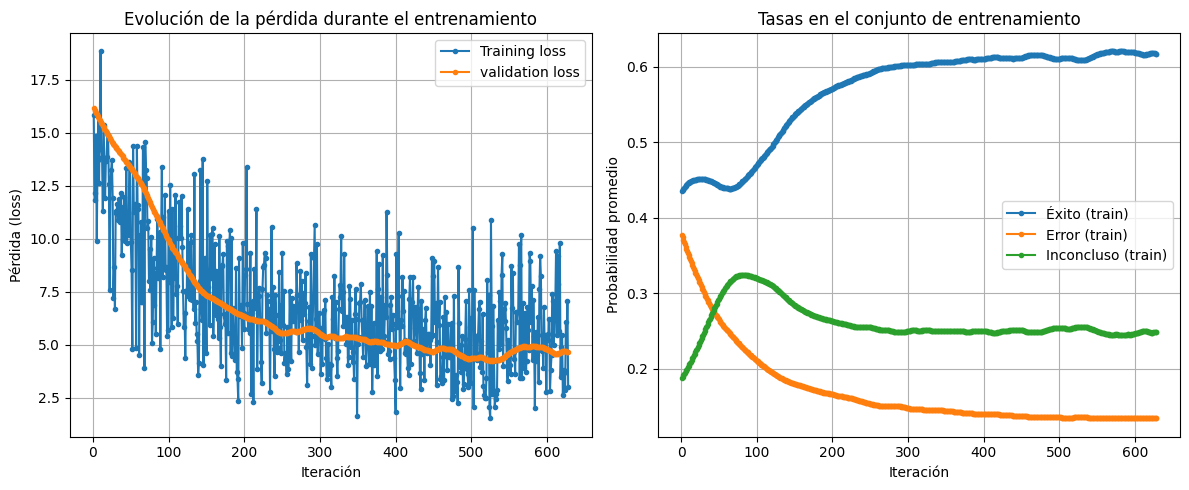

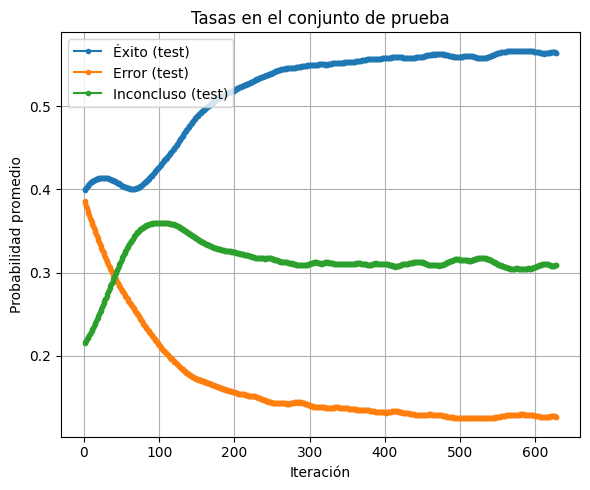

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

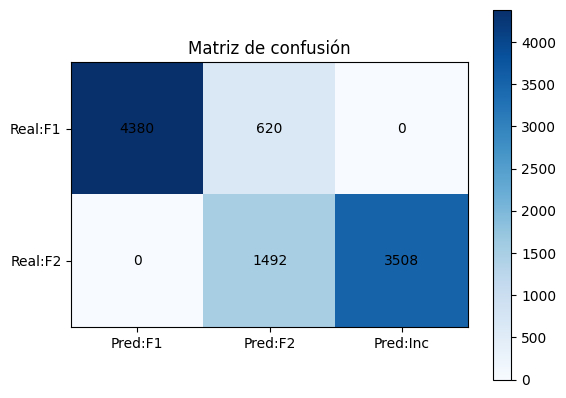

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
